In [1]:
import matplotlib
matplotlib.use('TkAgg')
#from plotting import user_rc

In [2]:
%matplotlib inline

In [3]:
run apogee_lcs.py 5285607

/Users/diana/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Isodata.cat already exists; loaded.
LC data for KIC 5285607 loaded.
Excluding  []
Clip tolerance = 1.5


NameError: name 'blah' is not defined

In [5]:
nwalkers=64
niter=40000
isonames = parnames_dict['lcrv']
iwalker = np.arange(nwalkers)
data = np.loadtxt('kics/5285607/lcrv_64x40k.mcmc')

NameError: name 'np' is not defined

In [5]:
prefix='kics/{0}/'.format(kic)
check_dir_exists(prefix)

Directory already exists.


In [70]:
msum, rsum, rrat, b, frat = lcpars_guess_init(keblat.phase[keblat.clip], 
                                          keblat.flux[keblat.clip], period, keblat.sep,
                                        keblat.swidth, keblat.pwidth, sdep, pdep)
#ew_trials = [[esinw, ecosw], [-esinw, ecosw], [-0.521, ecosw], [-0.332, ecosw], [-0.142, ecosw], [0.521, ecosw], [0.332, ecosw], [0.142, ecosw]]
#lcpars0 = np.array([msum, rsum, rrat, period, tpe, esinw, ecosw, b, frat, q1, q2, q3, q4])
#ew = ew_search_lmfit(ew_trials, lcpars0, (period, tpe, tpe+keblat.sep*period), fit_ecosw=False, polyorder=1)

b_trials = [0.1, 0.4, 0.8]
rrat_trials = [0.3, 0.5, 0.95]


#b_trials = [b] + [float(jj) for jj in np.array(b_trials)[~np.in1d(b_trials, b)]]
#rrat_trials = [rrat] + [float(jj) for jj in np.array(rrat_trials)[~np.in1d(rrat_trials, rrat)]]
lc_search_counts=0
bestlcchi2 = 1e25
ew = [esinw, ecosw]

In [71]:
print msum, rsum, rrat, b, frat, esinw, ecosw, ew
keblat.parbounds['b'][1] = 7.0
keblat.parbounds['mrat'] = [0.0085, 10.]
keblat.updatebounds('period', 'tpe')
if ecosw<0.01:
    keblat.updatebounds('ecosw')
if esinw<0.01:
    keblat.parbounds['ecosw'] = [-0.1, 0.1]
keblat.parbounds['rrat'] = [1e-5, 1.0]
print keblat.parbounds

1.36400267306 1.55809227178 [ 0.95] 0.1 [ 0.87964819] 0.0629183400268 -0.000942477796077 [0.062918340026773684, -0.00094247779607692134]
OrderedDict([('m1', [0.1, 12.0]), ('m2', [0.1, 12.0]), ('z0', [0.001, 0.06]), ('age', [6.0, 10.1]), ('dist', [10.0, 15000.0]), ('ebv', [0.0, 1.0]), ('h0', [118.0, 120.0]), ('period', [3.8214130812308453, 3.9773891253627167]), ('tpe', [124.04612992378273, 129.10923726761058]), ('esinw', [-0.99, 0.99]), ('ecosw', [0.0001266346710499533, 0.00013180343313362486]), ('b', [0.0, 7.0]), ('q1', [0.0, 1.0]), ('q2', [0.0, 1.0]), ('q3', [0.0, 1.0]), ('q4', [0.0, 1.0]), ('lcerr', [0.0, 0.01]), ('isoerr', [0.0, 0.3]), ('k0', [-39212.260000000002, 161694.81]), ('rverr', [0.0, 10000.0]), ('msum', [0.2, 24.0]), ('mrat', [0.0085, 10.0]), ('rsum', [0.1, 1000000.0]), ('rrat', [1e-05, 1.0]), ('r1', [0.01, 1000000.0]), ('r2', [0.01, 1000000.0]), ('inc', [0.0, 1.5707963267948966]), ('frat', [1e-08, 100.0])])


In [72]:
###################################################################################
########################### LC ONLY OPTIMIZATION FIRST ############################
###################################################################################

# for i_b, i_rrat, i_ew in list(itertools.product(b_trials, rrat_trials, ew_trials)):
for i_b, i_rrat in list(itertools.product(b_trials, rrat_trials)):
    # lcpars0 = np.array([rsum, rsum, i_rrat, period, tpe, ew[0], ew[1], i_b, i_rrat**(2.5),
    #                     q1, q2, q3, q4])
    upper_b = 2.*i_b if i_b==0.01 else 3.0
    keblat.parbounds['b'][1] = upper_b
    opt_lcpars0 = opt_lc(msum=rsum, rsum=rsum, rrat=i_rrat, period=period, tpe=tpe, esinw=ew[0],
                         ecosw=ew[1], b=i_b, frat=i_rrat**2.5, q1=q1, q2=q2, q3=q3, q4=q4)

    lcchi2 = np.sum(rez(opt_lcpars0, polyorder=2)**2)/(np.sum(keblat.clip) - len(opt_lcpars0) - 1)
    if (lcchi2 < bestlcchi2) or (lc_search_counts < 1):
        print "Saving from this run:", lcchi2, bestlcchi2, lc_search_counts
        bestlcchi2 = lcchi2*1.0
        opt_lcpars = opt_lcpars0
    lc_search_counts+=1

    if (bestlcchi2 <= 1.5) and opt_lcpars[2]<=1.0:
        print "These init b, rrat, esinw, ecosw lcpars are: ", i_b, i_rrat, ew
        break

==================== Starting LIGHTCURVE ONLY fit... =====================
[[Fit Statistics]]
    # function evals   = 672
    # data points      = 15898
    # variables        = 7
    chi-square         = 390685.495
    reduced chi-square = 24.585
    Akaike info crit   = 50914.779
    Bayesian info crit = 50968.496
[[Variables]]
    q1:       0.01 (fixed)
    q2:       0.01 (fixed)
    tpe:      126.577522 +/- 0        (0.00%) (init= 126.576)
    b:        1.51142067 +/- 0        (0.00%) (init= 0.1)
    ecosw:    0.00012663 +/- 0        (0.00%) (init= 0.0001266347)
    q4:       0.01 (fixed)
    rsum:     3.00200008 +/- 0        (0.00%) (init= 1.558092)
    period:   3.899401 (fixed)
    q3:       0.01 (fixed)
    msum:     1.558092 (fixed)
    frat:     0.63766982 +/- 0        (0.00%) (init= 0.04929503)
    rrat:     0.81153582 +/- 0        (0.00%) (init= 0.3)
    esinw:    0.00201509 +/- 0        (0.00%) (init= 0.06291834)
[[Correlations]] (unreported correlations are <  0.100)
pol

In [73]:
print opt_lcpars, keblat.pars

[  1.69622946e+00   3.05848688e+00   7.98174276e-01   3.89940110e+00
   1.26577504e+02   2.59208748e-03   1.26634671e-04   1.48010372e+00
   6.14501938e-01   3.24914544e-01   1.15075286e-01   2.66990419e-01
   3.64543180e-01] OrderedDict([('m1', None), ('m2', None), ('z0', None), ('age', None), ('dist', None), ('ebv', None), ('h0', None), ('period', 3.8994011), ('tpe', 126.57621262140323), ('esinw', -0.17877178829682228), ('ecosw', 0.0001266346710499533), ('b', 1.8137580546253258), ('q1', 0.01), ('q2', 0.01), ('q3', 0.01), ('q4', 0.01), ('lcerr', None), ('isoerr', None), ('k0', None), ('rverr', None), ('msum', 1.5580922717833185), ('mrat', None), ('rsum', 0.58217203359990344), ('rrat', 5.2474007842654937e-05), ('r1', 0.58214148630298557), ('r2', 3.0547296917797672e-05), ('inc', 1.4833541037782414), ('frat', 1.4953189106869136)])


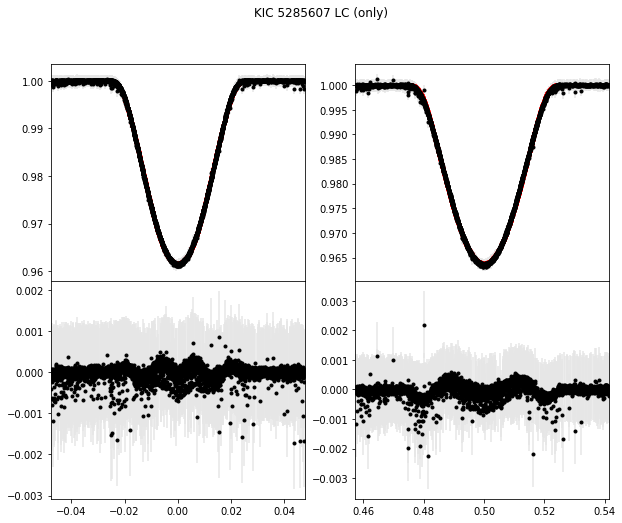

In [6]:
opt_lcpars = np.loadtxt('kics/5285607/lcpars2.lmfit')
try:
    make_lc_plots(kic, opt_lcpars, prefix, polyorder=2, suffix='lc_opt2', savefig=False)
except Exception, e:
    print str(e)

#if bestlcchi2 < lcchi2_threshold:
#    print "Saving lmfit lcpars..."
#    np.savetxt(prefix+'lcpars.lmfit', opt_lcpars)

In [7]:
keblat.parbounds['esinw'] = [-0.01, 0.01]
keblat.parbounds['ecosw'] = [-0.01, 0.01]
keblat.parbounds['period'] = [0.9999*opt_lcpars[3], 1.0001*opt_lcpars[3]]
keblat.parbounds['tpe'] = [0.9999*opt_lcpars[4], 1.0001*opt_lcpars[4]]
keblat.parbounds['rrat'] = [0.1, 10.]
keblat.parbounds['frat'] = [0.5, .7]

In [8]:
lcpars2 = opt_lc(msum=opt_lcpars[0], rsum=opt_lcpars[1], rrat=0.9, 
                 period=opt_lcpars[3], tpe=opt_lcpars[4],
                 esinw=opt_lcpars[5], ecosw=opt_lcpars[6], b=opt_lcpars[7], 
                 frat=0.6, q1=opt_lcpars[9],
                 q2=opt_lcpars[10], q3=opt_lcpars[11], 
                 q4=opt_lcpars[12], vary_msum=False)

==================== Starting LIGHTCURVE ONLY fit... =====================
[[Fit Statistics]]
    # function evals   = 79
    # data points      = 15899
    # variables        = 7
    chi-square         = 373373.362
    reduced chi-square = 23.494
    Akaike info crit   = 50196.374
    Bayesian info crit = 50250.092
[[Variables]]
    q1:       2.318661e-08 (fixed)
    q2:       2.408965e-05 (fixed)
    tpe:      126.577679 +/- 9.51e-06 (0.00%) (init= 126.5776)
    b:        1.55522891 +/- 0.295588 (19.01%) (init= 0.9736113)
    ecosw:   -9.0552e-06 +/- 5.50e-06 (60.78%) (init= 8.318497e-06)
    q4:       0.09273825 (fixed)
    rsum:     3.02506536 +/- 0.046097 (1.52%) (init= 2.875565)
    period:   3.899401 (fixed)
    q3:       0.09009087 (fixed)
    msum:     1.58354 (fixed)
    frat:     0.69976243 +/- 0.564427 (80.66%) (init= 0.6)
    rrat:     0.86447878 +/- 0.341133 (39.46%) (init= 0.9)
    esinw:   -0.00386762 +/- 0.000317 (8.20%) (init= 0.01)
[[Correlations]] (unreported correl

True

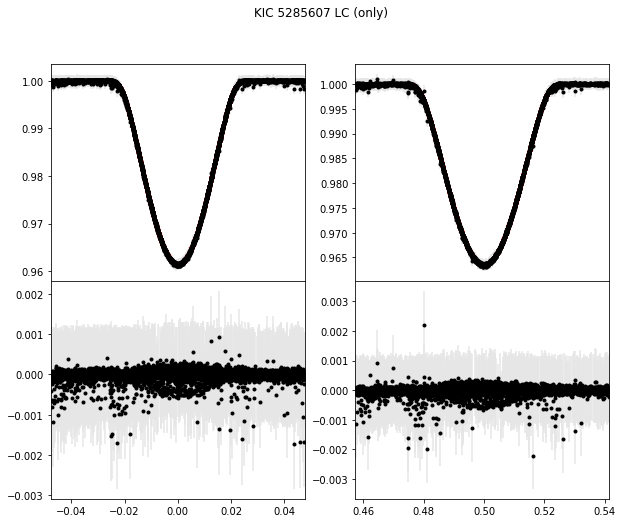

In [9]:
make_lc_plots(kic, lcpars2, prefix, polyorder=2, suffix='lc_opt2', savefig=False)

In [10]:
t, rv1, rv1err, rv2, rv2err = np.loadtxt('data/5285607_jm.rv.txt', usecols=(2, 3, 4, 5, 6), unpack=True)

In [11]:
m1, m2, k0 = keblat.rvprep(t, rv1*1e3, rv2*1e3, rv1err*1e3, rv2err*1e3)

In [12]:
phase = (t-keblat.pars['tpe'])%keblat.pars['period']/keblat.pars['period']

Populating the interactive namespace from numpy and matplotlib


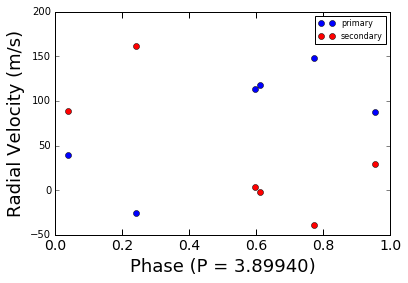

In [78]:
%pylab inline
plt.plot(phase, rv1, 'bo', label='primary')
plt.plot(phase, rv2, 'ro', label='secondary')
plt.xlabel('Phase (P = {0:.5f})'.format(keblat.pars['period']))
plt.ylabel('Radial Velocity (m/s)')
plt.legend(fontsize=8)
plt.show()

In [13]:
keblat.updatepars(m1=m1, m2=m2, msum=m1+m2, mrat=m2/m1)
keblat.updatebounds('period', 'tpe', 'msum', 'mrat')
rvpars = [m1+m2, m2/m1, opt_lcpars[3], opt_lcpars[4], opt_lcpars[5], opt_lcpars[6], keblat.pars['inc'], k0, 0]
opt_rvpars = opt_rv(msum=m1+m2, mrat=m2/m1, period=opt_lcpars[3], tpe=opt_lcpars[4], esinw=opt_lcpars[5],
                       ecosw=opt_lcpars[6], inc=keblat.pars['inc'], k0=k0, rverr=0)

rverr 0
tpe 126.57764355
ecosw 8.31849735838e-06
mrat 0.861929050083
period 3.89940110974
msum 2.64115072994
k0 63928.32
esinw 0.419608054234
inc 1.36529222486
========================= Starting RV ONLY fit... ========================
Parameters([('rverr', <Parameter 'rverr', value=0 (fixed), bounds=[0.0:10000.0]>), ('tpe', <Parameter 'tpe', value=126.57764354984801 (fixed), bounds=[124.04609809020387:129.109204134702]>), ('ecosw', <Parameter 'ecosw', 8.3184973583838584e-06, bounds=[-0.01:0.01]>), ('mrat', <Parameter 'mrat', 0.86192905008270759, bounds=[0.8446904690810535:0.87916763108436169]>), ('period', <Parameter 'period', value=3.8994011097352526 (fixed), bounds=[3.8214130959584502:3.9773891406914479]>), ('msum', <Parameter 'msum', 2.6411507299367258, bounds=[2.5883277153379911:2.6939737445354606]>), ('k0', <Parameter 'k0', 63928.32, bounds=[-39212.260000000002:161694.81]>), ('esinw', <Parameter 'esinw', 0.01, bounds=[-0.01:0.01]>), ('inc', <Parameter 'inc', 1.3652922248560104, bo

True

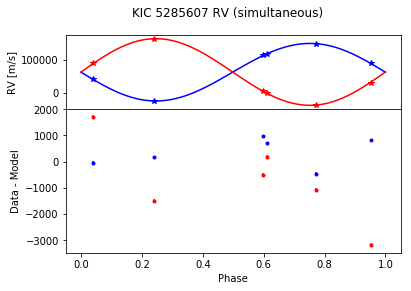

In [14]:
keblat.plot_rv(opt_rvpars, prefix, savefig=False)

In [15]:
opt_lcpars = lcpars2.copy()
opt_lcpars[0] = opt_rvpars[0]
lcpars2 = opt_lc(msum=m1+m2, rsum=opt_lcpars[1], rrat=opt_lcpars[2], period=opt_lcpars[3], tpe=opt_lcpars[4],
                 esinw=0.02, ecosw=opt_lcpars[6], b=opt_lcpars[7], frat=opt_lcpars[8], q1=opt_lcpars[9],
                 q2=opt_lcpars[10], q3=opt_lcpars[11], q4=opt_lcpars[12], vary_msum=False)

==================== Starting LIGHTCURVE ONLY fit... =====================
[[Fit Statistics]]
    # function evals   = 132
    # data points      = 15900
    # variables        = 7
    chi-square         = 299658.443
    reduced chi-square = 18.855
    Akaike info crit   = 46701.555
    Bayesian info crit = 46755.273
[[Variables]]
    q1:       0.3176323 (fixed)
    q2:       0.1563557 (fixed)
    tpe:      126.577651 +/- 0        (0.00%) (init= 126.5777)
    b:        1.53767730 +/- 0        (0.00%) (init= 1.545059)
    ecosw:   -2.5046e-06 +/- 0        (0.00%) (init= 2.476796e-07)
    q4:       7.460942e-05 (fixed)
    rsum:     3.58398167 +/- 0        (0.00%) (init= 3.008053)
    period:   3.899401 (fixed)
    q3:       0.398826 (fixed)
    msum:     2.641151 (fixed)
    frat:     0.69999999 +/- 0        (0.00%) (init= 0.6994274)
    rrat:     0.86659604 +/- 0        (0.00%) (init= 0.8736374)
    esinw:    0.00063084 +/- 0        (0.00%) (init= 0.01)
[[Correlations]] (unreported cor

In [18]:
keblat.parbounds['mrat'] = [0.8, 1.0]
#keblat.parbounds['msum'] = [2.5, 2.8]
keblat.parbounds['frat'] = [0.45, 0.75]
keblat.parbounds['k0'] = [50000., 70000.]

In [19]:
opt_lcrvpars = opt_lcrv(msum=opt_rvpars[0], mrat=opt_rvpars[1],
                        rsum=lcpars2[1], rrat=0.9, period=lcpars2[3],
                        tpe=lcpars2[4], esinw=lcpars2[5], ecosw=lcpars2[6],
                        b=lcpars2[7], frat=0.6, q1=lcpars2[-4],
                        q2=lcpars2[-3], q3=lcpars2[-2], q4=lcpars2[-1],
                        lcerr=0.0, k0=opt_rvpars[-2], rverr=0.)

================= Starting LC + RV simultaneous fit... ===================
14.3450989175 14.3602589075
[[Fit Statistics]]
    # function evals   = 263
    # data points      = 15912
    # variables        = 17
    chi-square         = 228256.315
    reduced chi-square = 14.360
    Akaike info crit   = 42413.952
    Bayesian info crit = 42544.424
[[Variables]]
    q1:       0.37036351 +/- 0        (0.00%) (init= 0.3080389)
    q2:       0.00941873 +/- 0        (0.00%) (init= 0.1787807)
    tpe:      126.577651 +/- 0        (0.00%) (init= 126.5777)
    b:        1.47452289 +/- 0        (0.00%) (init= 1.538105)
    ecosw:   -2.3048e-06 +/- 0        (0.00%) (init=-2.276435e-06)
    q4:       0.25306717 +/- 0        (0.00%) (init= 0.1512873)
    rsum:     3.57689691 +/- 0        (0.00%) (init= 3.559942)
    mrat:     0.87686030 +/- 0        (0.00%) (init= 0.8633158)
    period:   3.89940111 +/- 0        (0.00%) (init= 3.899401)
    q3:       0.33226102 +/- 0        (0.00%) (init= 0.3369313)

True

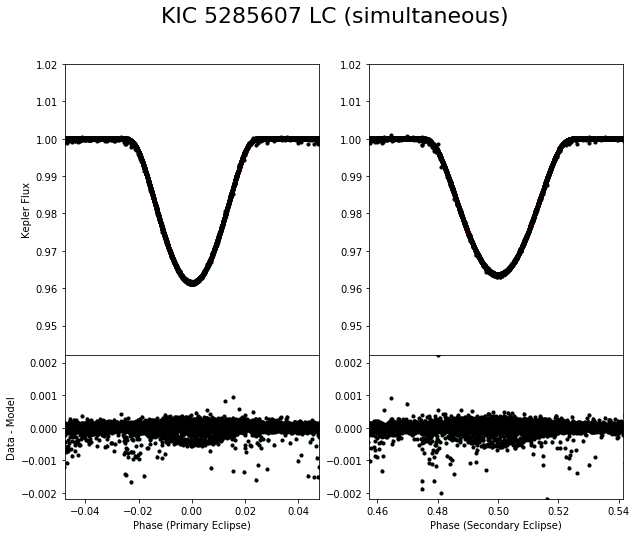

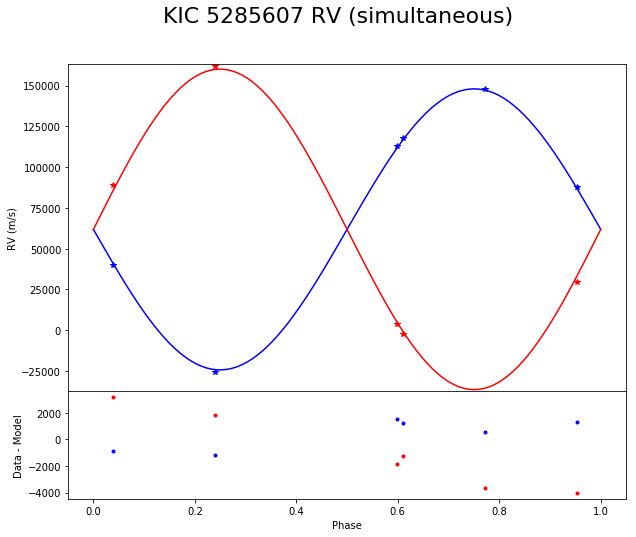

In [20]:
plt.rc('figure', titlesize=22)

def make_lcrv_plots(kic, allpars, prefix, suffix='', savefig=True, polyorder=2, ooe=True):
    residuals = lnlike_lcrv(allpars, qua=np.unique(keblat.quarter), polyorder=polyorder,
                            residual=True)
    lcpars = keblat.getpars(partype='lc')[:13]
    lcmod, lcpol = keblat.lcfit(lcpars, keblat.jd[keblat.clip], keblat.quarter[keblat.clip],
    				keblat.flux[keblat.clip], keblat.fluxerr[keblat.clip],
    				keblat.crowd[keblat.clip], polyorder=2, ooe=ooe)

    phase = ((keblat.jd[keblat.clip]-lcpars[4]) % lcpars[3])/lcpars[3]
    phase[phase<-np.clip(keblat.pwidth*3., 0., 0.2)]+=1.
    phase[phase>np.clip(keblat.sep+keblat.swidth*3., keblat.sep, 1.0)]-=1.

    lcres = keblat.flux[keblat.clip] - lcmod*lcpol

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(121)
    ax.plot(keblat.phase[keblat.clip], keblat.flux[keblat.clip]/lcpol, 'g.', alpha=0.4)
    ax.errorbar(phase, keblat.flux[keblat.clip]/lcpol,
                 keblat.fluxerr[keblat.clip], fmt='k.', ecolor='gray')
    ax.plot(phase, lcmod, 'r.')
    ax.set_xlim((-1.2*keblat.pwidth, 1.2*keblat.pwidth))
    ax.set_ylim((np.min(lcmod)*0.98, np.max(lcmod)*1.02))
    ax.set_ylabel('Kepler Flux')

    divider = make_axes_locatable(ax)
    axb = divider.append_axes("bottom", size=2.0, pad=0, sharex=ax)
    axb.plot(keblat.phase[keblat.clip], lcres, 'g.', alpha=0.4)
    axb.errorbar(phase, lcres,
                 np.sqrt(keblat.fluxerr[keblat.clip]**2 + keblat.pars['lcerr']**2), fmt='k.', ecolor='gray')

    axb.set_xlim((-1.2*keblat.pwidth, 1.2*keblat.pwidth))
    axb.set_ylim((np.min(lcres), np.max(lcres)))
    axb.set_ylabel('Data - Model')
    axb.set_xlabel('Phase (Primary Eclipse)')
    #axb.set_yticklabels(axb.yaxis.get_majorticklabels()[1:])

    ax2 = fig.add_subplot(122)
    ax2.plot(keblat.phase[keblat.clip], keblat.flux[keblat.clip]/lcpol, 'g.', alpha=0.4)
    ax2.errorbar(phase, keblat.flux[keblat.clip]/lcpol,
                 keblat.fluxerr[keblat.clip], fmt='k.', ecolor='gray')
    ax2.plot(phase, lcmod, 'r.')
    ax2.set_xlim((-1.2*keblat.swidth+keblat.sep, 1.2*keblat.swidth+keblat.sep))
    ax2.set_ylim((np.min(lcmod)*0.98, np.max(lcmod)*1.02))

    divider2 = make_axes_locatable(ax2)
    ax2b = divider2.append_axes("bottom", size=2.0, pad=0, sharex=ax2)
    ax2b.plot(keblat.phase[keblat.clip], lcres, 'g.', alpha=0.4)
    ax2b.errorbar(phase, lcres,
                 np.sqrt(keblat.fluxerr[keblat.clip]**2 + keblat.pars['lcerr']**2), fmt='k.', ecolor='gray')

    ax2b.set_xlim((-1.2*keblat.swidth+keblat.sep, 1.2*keblat.swidth+keblat.sep))
    ax2b.set_ylim((np.min(lcres), np.max(lcres)))
    ax2b.set_xlabel('Phase (Secondary Eclipse)')

    #ax2b.set_yticklabels(ax2b.yaxis.get_majorticklabels()[1:])


    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.suptitle('KIC '+str(kic)+' LC (simultaneous)')
    if savefig:
        plt.savefig(prefix+suffix+'_LC.png')

    # rvpars = keblat.getpars(partype='rv')
    rvpars = np.array([keblat.pars['msum'], keblat.pars['mrat'], keblat.pars['period'], keblat.pars['tpe'],
                       keblat.pars['esinw'], keblat.pars['ecosw'], keblat.pars['inc'], keblat.pars['k0'], keblat.pars['rverr']])

    rv_fit = keblat.rvfit(rvpars, keblat.rv_t)
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    rvphase = (keblat.rv_t - keblat.pars['tpe'])%keblat.pars['period']/keblat.pars['period']
    ax.errorbar(rvphase[~keblat.bad1], keblat.rv1_obs[~keblat.bad1], keblat.rv1_err_obs[~keblat.bad1], fmt='b*')
    ax.errorbar(rvphase[~keblat.bad2], keblat.rv2_obs[~keblat.bad2], keblat.rv2_err_obs[~keblat.bad2], fmt='r*')
    rvt = np.linspace(0, 1, 100)*keblat.pars['period']+keblat.pars['tpe']
    rvmod = keblat.rvfit(rvpars, rvt)
    ax.plot(np.linspace(0, 1, 100), rvmod[0], 'b-')
    ax.plot(np.linspace(0, 1, 100), rvmod[1], 'r-')
    ax.set_ylabel('RV (m/s)')
    ax.set_ylim(min(np.nanmin(rvmod[0]), 
                    np.nanmin(rvmod[1]))-(0.02*abs(min(np.nanmin(rvmod[0]), 
                    np.nanmin(rvmod[1])))),
               max(np.nanmax(rvmod[0]), 
                    np.nanmax(rvmod[1]))+ (0.02*abs(max(np.nanmax(rvmod[0]), 
                    np.nanmax(rvmod[1])))))
    #ax.set_yticklabels(ax.yaxis.get_majorticklabels()[:-1])

    divider = make_axes_locatable(ax)
    ax2 = divider.append_axes("bottom", size=1.5, pad=0, sharex=ax)
    ax2.errorbar(rvphase[~keblat.bad1], (keblat.rv1_obs-rv_fit[0])[~keblat.bad1], np.sqrt(keblat.rv1_err_obs**2+rvpars[-1]**2)[~keblat.bad1], fmt='b.')
    ax2.errorbar(rvphase[~keblat.bad2], (keblat.rv2_obs-rv_fit[1])[~keblat.bad2], np.sqrt(keblat.rv2_err_obs**2+rvpars[-1]**2)[~keblat.bad2], fmt='r.')

    ax2.set_xlabel('Phase')
    ax2.set_ylabel('Data - Model')
    #ax2.set_yticklabels(ax2.yaxis.get_majorticklabels()[:-1])
    plt.setp(ax.get_xticklabels(), visible=False)
    #plt.setp(ax2.get_yticklabels()[-1], visible=False)

    plt.suptitle('KIC '+str(kic)+' RV (simultaneous)')
    if savefig:
        plt.savefig(prefix+suffix+'_RV.png')

    return True

make_lcrv_plots(kic, opt_lcrvpars, prefix, suffix='lcrv', savefig=False, polyorder=2)
#keblat.plot_lcrv(opt_lcrvpars, prefix, savefig=True)
#np.savetxt(prefix+'lcrv.lmfit', opt_lcrvpars)

In [22]:
keblat.parbounds

OrderedDict([('m1', [0.1, 12.0]),
             ('m2', [0.1, 12.0]),
             ('z0', [0.001, 0.06]),
             ('age', [6.0, 10.1]),
             ('dist', [10.0, 15000.0]),
             ('ebv', [0.0, 1.0]),
             ('h0', [118.0, 120.0]),
             ('period', [3.8214130959584502, 3.9773891406914479]),
             ('tpe', [124.04609809020387, 129.109204134702]),
             ('esinw', [-0.01, 0.01]),
             ('ecosw', [-0.01, 0.01]),
             ('b', [-7.0, 7.0]),
             ('q1', [0.0, 1.0]),
             ('q2', [0.0, 1.0]),
             ('q3', [0.0, 1.0]),
             ('q4', [0.0, 1.0]),
             ('lcerr', [0.0, 0.01]),
             ('isoerr', [0.0, 0.3]),
             ('k0', [50000.0, 70000.0]),
             ('rverr', [0.0, 10000.0]),
             ('msum', [2.5883277153379911, 2.6939737445354606]),
             ('mrat', [0.8, 1.0]),
             ('rsum', [0.1, 1000000.0]),
             ('rrat', [0.1, 10.0]),
             ('r1', [0.01, 1000000.0]),
      

In [117]:
parnames_dict['lcrv']

['msum',
 'mrat',
 'rsum',
 'rrat',
 'period',
 'tpe',
 'esinw',
 'ecosw',
 'b',
 'frat',
 'q1',
 'q2',
 'q3',
 'q4',
 'lcerr',
 'k0',
 'rverr']

In [116]:
bounds = np.array([keblat.parbounds[ii] for ii in ['msum', 'mrat', 'rsum', 
                   'rrat', 'period', 'tpe', 'esinw', 'b', 'frat', 
                       'q1', 'q2', 'q3', 'q4', 'lcerr', 'k0', 'rverr']])
print bounds[:,0]

[  2.50000000e+00   8.00000000e-01   1.00000000e-01   1.00000000e-05
   3.82141308e+00   1.24045954e+02  -9.90000000e-01   0.00000000e+00
   1.00000000e-08   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -3.92122600e+04   0.00000000e+00]


In [23]:
np.savetxt('data/{0}.opt_lcrv_BFconstraint'.format(kic), opt_lcrvpars)

In [24]:
# update period, tpe parameter bounds (default is sets to +/- 2% of current value)
keblat.updatebounds('period', 'tpe')
opt_lcrvpars = opt_lcrvpars.copy()
# the lcrv lnprob and lnprior functions take in rverr and lcerr in natural log space,
# so setting them to small log values
opt_lcrvpars[-1] = -4 #rverr in m/s
opt_lcrvpars[-3] = -11 #lcerr in kep flux

In [47]:
keblat.parbounds['k0'] = [40000., 80000.]
keblat.parbounds['msum'] = [1.5, 3.3]

In [32]:
def lnprob_lcrv(lcrvpars, qua=[1]):
    lcrvpars0 = lcrvpars.copy()
    lp = keblat.lnprior_lcrv(lcrvpars0)
    if np.isinf(lp):
        return -np.inf
    lcrvpars0[-1] = np.exp(lcrvpars0[-1])
    lcrvpars0[-3] = np.exp(lcrvpars0[-3])
    ll = keblat.lnlike_lcrv(lcrvpars0, qua=qua)
    if (np.isnan(ll) or np.isinf(ll)):
        return -np.inf
    return lp + ll

# make run emcee into a function, it takes in 
# pars = optimized parameters, mcfile = name of MCMC output file,
# p0_scale = scale of how big the init. Gaussian ball is (e.g., 1e-4),
# nwalkers and niter
def run_emcee(pars, mcfile, p0_scale=None, nwalkers=64, niter=40000, clobber=True):
    assert keblat.rv_t is not None, "no rv data found"
    assert keblat.jd is not None, "no lc data found"
    ndim = len(pars)
    print ndim
    if p0_scale is None:
        p0_scale = np.ones(ndim)*1e-4
    p0 = [pars + p0_scale*pars*np.random.randn(ndim) for ii in range(nwalkers)]
    p0 = np.array(p0)
    ll0 = np.zeros(nwalkers)
    for ii in range(nwalkers):
        ll0[ii] = lnprob_lcrv(p0[ii,:], qua=np.unique(keblat.quarter))
    if np.any(np.isinf(ll0)):
        print("Initial Gaussian ball of parameters yield -inf lnprob, check bounds")
        return p0, ll0
    print p0[0,:]
    if os.path.isfile(mcfile) and not clobber:
        print("File {0} already exists... do you want to clobber?".format(mcfile))
        return
    outf=open(mcfile, "w")
    outf.close()

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_lcrv, threads=4,
                                         args=[np.unique(keblat.quarter)])
    start_time = time.time()
    print("Running {0}k MCMC chain".format(niter/1000))
    for res in sampler.sample(p0, iterations=niter, storechain=False):
        if sampler.iterations % 10 == 0:
            position = res[0]
            outf = open(mcfile, "a")
            for k in range(position.shape[0]):
                outf.write("{0} {1} {2} {3} {4}\n".format(sampler.iterations,
                           k, sampler.acceptance_fraction[k], res[1][k],
                            " ".join([str(ii) for ii in position[k]])))
            outf.close()
        if sampler.iterations % 10000 == 0:
            print("Time elapsed since niter={0}:{1}".format(sampler.iterations, 
                  time.time()-start_time))
    print("Total time elapsed for MCMC run:{0}".format(time.time()-start_time))
    print("Total acceptance fraction:{0}".format(np.mean(sampler.acceptance_fraction)))
    try:
        print("Total autocorr time:{0}".format(np.mean(sampler.acor)))
    except:
        print("Could not compute autocorr time...")
    return p0, sampler

In [33]:
ndim = len(opt_lcrvpars)
nwalkers = 64
#try a small number of iterations initially to see if it's working / what's going on
#once you think it's working well, go up to 10,000 - 50,000 (this will take a while)
niter = 40000 
header = prefix+'lcrv_BFconstraint'
footer = str(nwalkers)+'x'+str(niter/1000)+'k'
mcfile = header+footer+'.mcmc'

In [49]:
p0_scale = np.ones(ndim)*1e-4
p0_scale[4] = 1e-7
p0_scale[5] = 1e-6
p0_scale[[1,3,9]] = 1e-5
p0, sampler = run_emcee(opt_lcrvpars, mcfile, p0_scale=p0_scale, nwalkers=nwalkers, niter=niter)

17
[  2.69354182e+00   8.76850288e-01   3.57657490e+00   7.92091850e-01
   3.89940082e+00   1.26577663e+02   1.71780023e-03  -5.06345794e-06
   1.47466958e+00   6.00003291e-01   3.69479284e-01   1.23532315e-02
   3.31219383e-01   2.55743572e-01  -1.10000287e+01   6.18153103e+04
  -3.99997003e+00]
Running 40k MCMC chain
Time elapsed since niter=10000:5140.43433785
Time elapsed since niter=20000:9899.05802298
Time elapsed since niter=30000:14336.728225
Time elapsed since niter=40000:18831.990252
Total time elapsed for MCMC run:18831.9959269
Total acceptance fraction:0.1436140625
Could not compute autocorr time...


/Users/diana/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [50]:
# these commands below will allow you to load in the MCMC file and make diagnostic plots
burnin=niter/2
data=np.loadtxt(mcfile)
isonames = parnames_dict['lcrv']
iwalker = np.arange(nwalkers)
afrac = np.empty((data.shape[0]/nwalkers, nwalkers))
logli = afrac*0.
params = np.empty((data.shape[0]/nwalkers, nwalkers, len(isonames)))
strays = []

for jj in iwalker:
    afrac[:,jj] = data[jj::nwalkers,2]
    logli[:,jj] = data[jj::nwalkers,3]
    if len(afrac[:,jj][(afrac[:,jj]<0.1)])>=0.66*len(afrac[:,jj]):
        strays.append(jj)
    for ii in range(len(isonames)):
        params[:, jj, ii] = data[jj::nwalkers, ii+4]

print("bad/stray walkers =", strays, len(strays))


('bad/stray walkers =', [42], 1)


Making plots now.
('Max likelihood out of all samples: ', array([ 131155.722214,  131155.722214,  131155.722214,  131155.722214,
        131155.722214,  131155.722214]))
msum = 2.91063015068
mrat = 0.867671448745
rsum = 3.66920268614
rrat = 0.859763271152
period = 3.89940118849
tpe = 126.57766044
esinw = -0.000680524227671
ecosw = -8.15639009823e-06
b = 1.53196528789
frat = 0.676271708373
q1 = 0.281561173591
q2 = 0.309026353241
q3 = 0.336086753721
q4 = 0.16189546273
lcerr = -8.79088210591
k0 = 61310.0487894
rverr = 7.32467503917


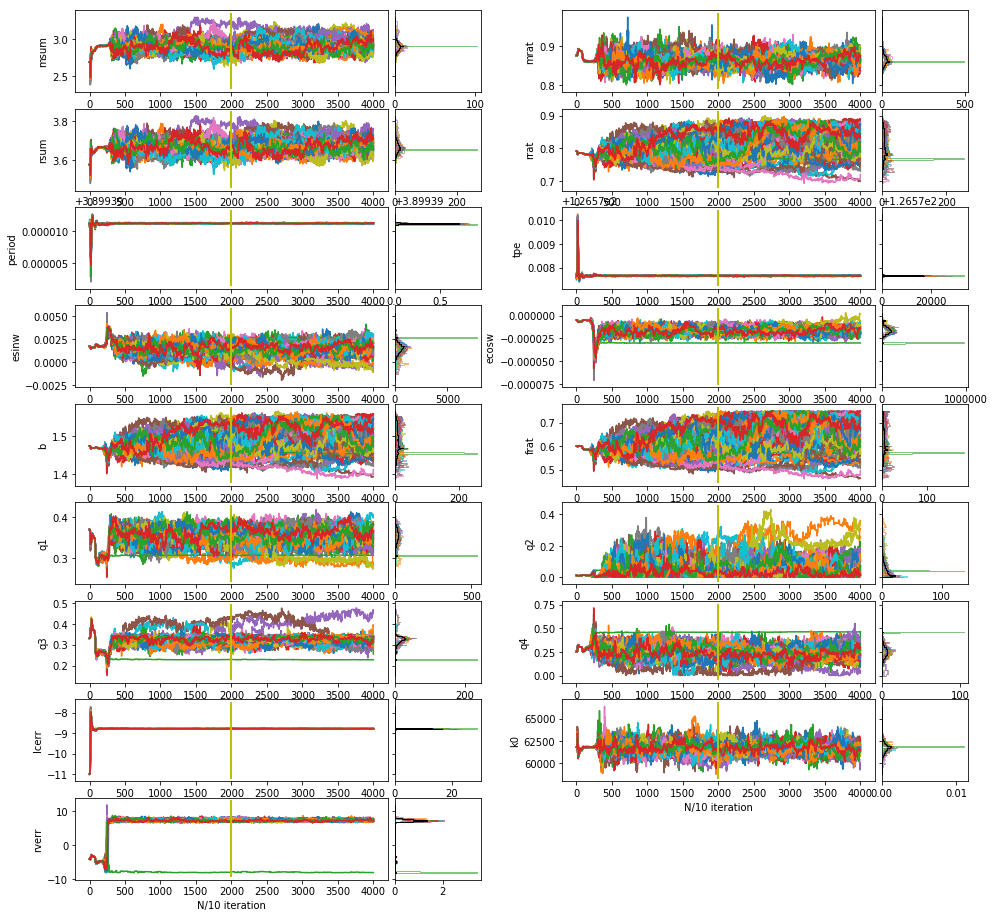

In [51]:
        
from mpl_toolkits.axes_grid1 import make_axes_locatable
print("Making plots now.")
fig = plt.figure(figsize=(16, 16))
for ii in range(len(isonames)):
    ax = fig.add_subplot(int(len(isonames)/2)+1, 2, ii+1)
    ax.plot(params[:, :, ii])
    ax.plot([burnin/10, burnin/10], plt.ylim(), 'y-', lw=2.0)
    ax.set_xlabel('N/10 iteration')
    ax.set_ylabel(isonames[ii])
    divider = make_axes_locatable(ax)
    axhist = divider.append_axes("right", size=1.2, pad=0.1, sharey=ax)
    axhist.hist(params[:,:,ii], 100, histtype='step', alpha=0.6, normed=True,
                orientation='horizontal')
    axhist.hist(params[:,:,ii].ravel(), 100, histtype='step', color='k',
                normed=True, orientation='horizontal')
    plt.setp(axhist.get_yticklabels(), visible=False)
plt.savefig(header+footer+'_parameters.png')

mostlike = np.where(logli == np.max(logli))
mlpars = params[:,:,:][mostlike][0]
print("Max likelihood out of all samples: ", logli[:,:][mostlike])
for kk in range(len(isonames)):
    print("""{0} = {1}""".format(str(isonames[kk]), mlpars[kk]))
if burnin/10>=params.shape[0]:
    print("Burn-in shorter than length of MCMC run, adjusting...")
    burnin = params.shape[0]*3/4*10
afrac, logli = afrac[burnin/10:,:], logli[burnin/10:,:]
params = params[burnin/10:,:,:]

keep = iwalker

('Max likelihood out of all samples: ', array([ 131155.722214,  131155.722214,  131155.722214,  131155.722214,
        131155.722214,  131155.722214]))
msum = 2.91063015068
mrat = 0.867671448745
rsum = 3.66920268614
rrat = 0.859763271152
period = 3.89940118849
tpe = 126.57766044
esinw = -0.000680524227671
ecosw = -8.15639009823e-06
b = 1.53196528789
frat = 0.676271708373
q1 = 0.281561173591
q2 = 0.309026353241
q3 = 0.336086753721
q4 = 0.16189546273
lcerr = -8.79088210591
k0 = 61310.0487894
rverr = 7.32467503917
Burn-in shorter than length of MCMC run, adjusting...
MCMC result: 
('Accep. Frac = ', 0.14602595131833726)
msum = 2.90947565979 +0.06953800886 -0.06190170858
mrat = 0.86537837039 +0.01271645311 -0.0118568899046
rsum = 3.67117938621 +0.0317185050274 -0.0272913064994
rrat = 0.823850636869 +0.0379904528887 -0.056327219605
period = 3.89940123965 +3.6346599952e-08 -4.57065993942e-08
tpe = 126.577662012 +1.11875000073e-05 -9.59550000346e-06
esinw = 0.00159412681258 +0.000566742686401

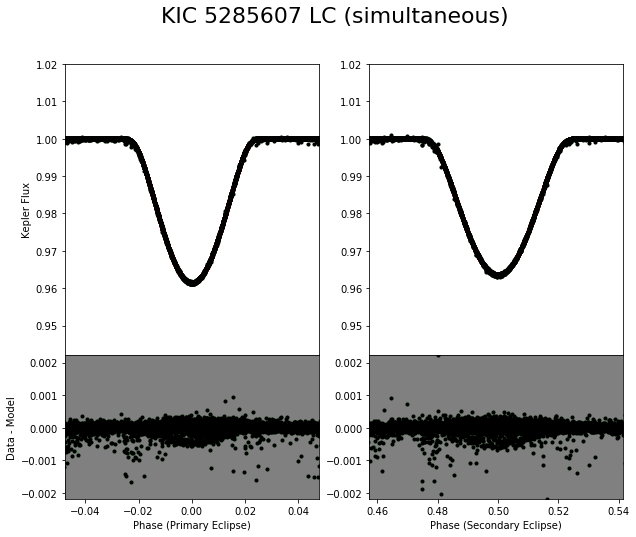

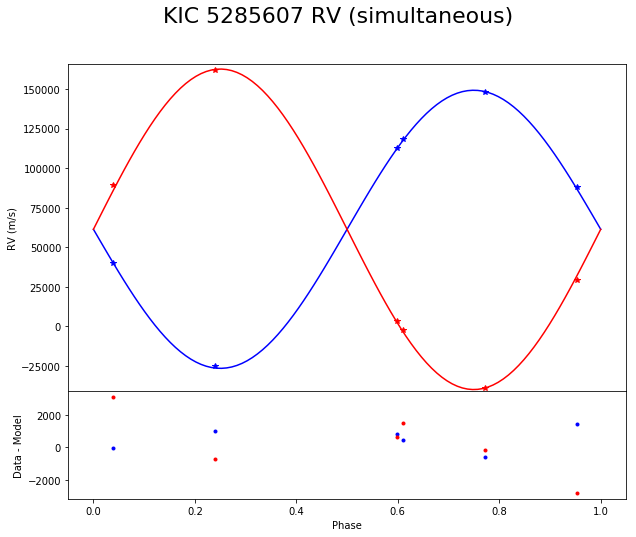

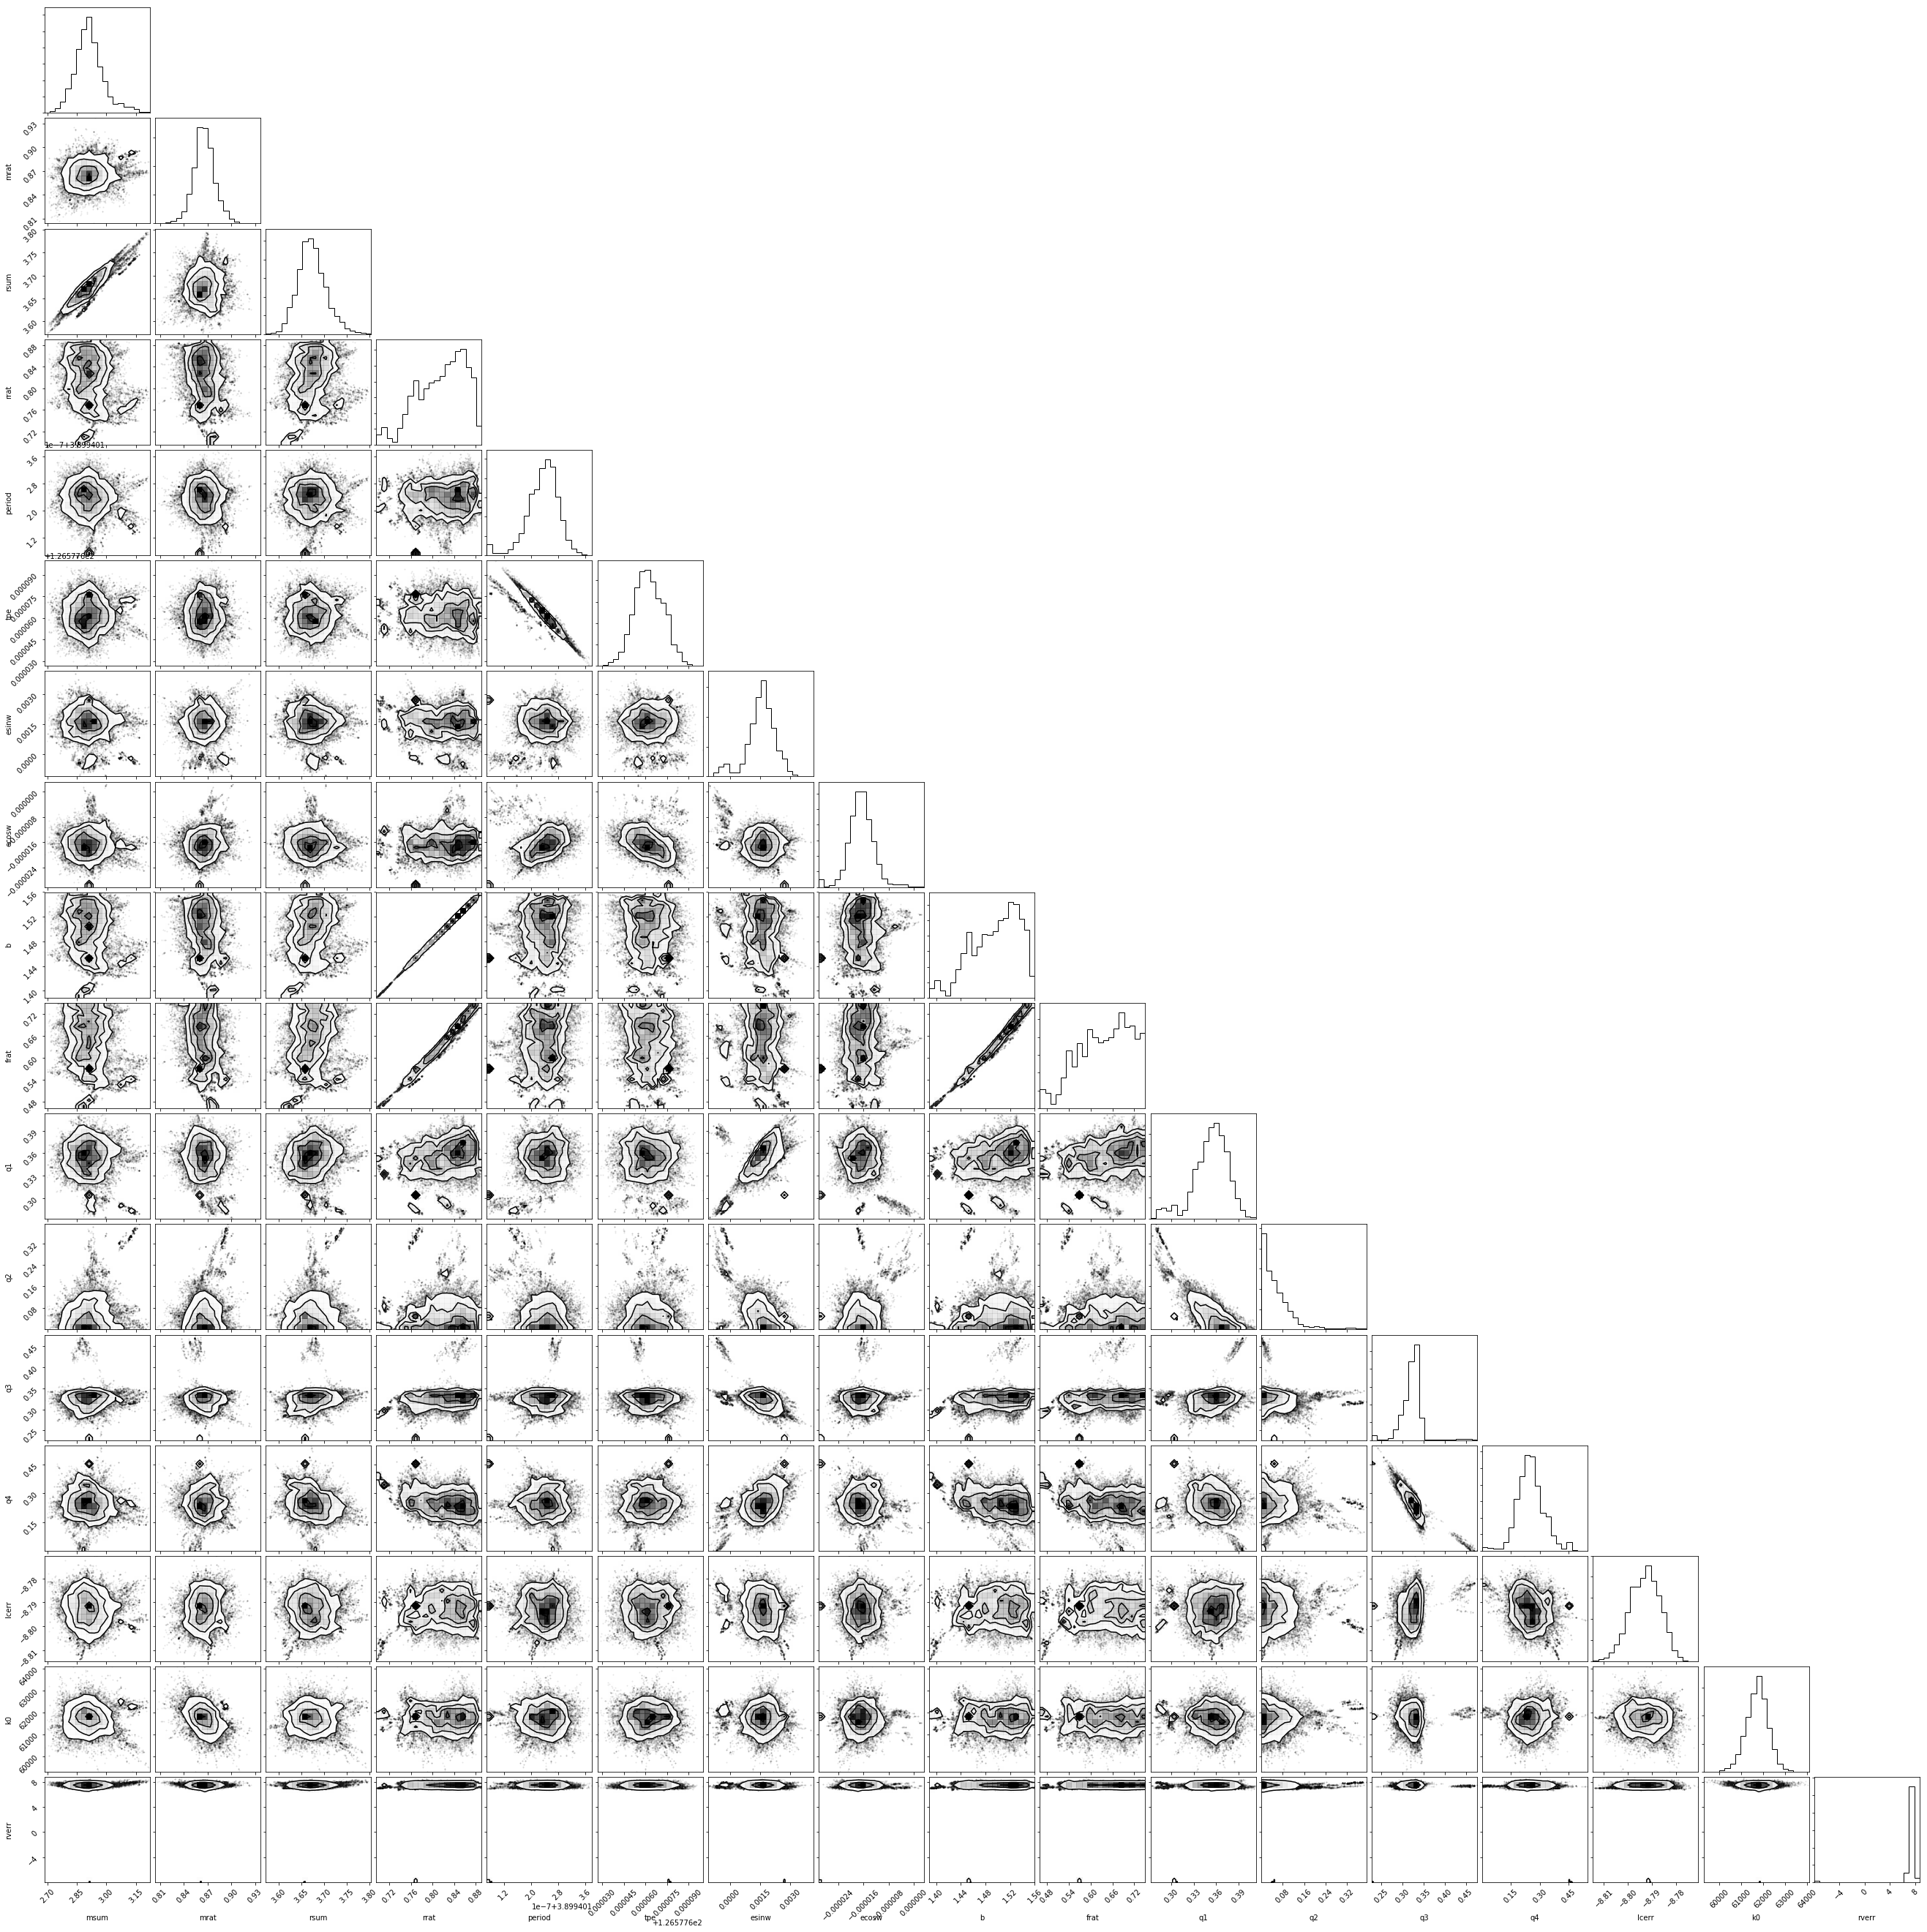

In [52]:
mostlike = np.where(logli == np.max(logli))
mlpars = params[:,:,:][mostlike][0]
print("Max likelihood out of all samples: ", logli[:,:][mostlike])
for kk in range(len(isonames)):
    print("""{0} = {1}""".format(str(isonames[kk]), mlpars[kk]))
if burnin/10>=params.shape[0]:
    print("Burn-in shorter than length of MCMC run, adjusting...")
    burnin = params.shape[0]*3/4*10
afrac, logli = afrac[burnin/10:,:], logli[burnin/10:,:]
params = params[burnin/10:,:,:]

keep = iwalker
bfpars = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
             zip(*np.percentile(params[:,keep,:].reshape((-1, ndim)),
                                [16, 50, 84], axis=0)))
print("MCMC result: ")
print("Accep. Frac = ", np.mean(afrac[:, keep]))
for kk in range(len(isonames)):
    print("""{0} = {1[0]} +{1[1]} -{1[2]}""".format(str(isonames[kk]),
          bfpars[kk]))

bfpars[-1] = np.exp(bfpars[-1])
bfpars[-3] = np.exp(bfpars[-3])
make_lcrv_plots(kic, mlpars, header+footer, suffix='', savefig=True)

import corner
#plt.figure(figsize=(14, 14))
samples = params[:, :, :]
post_inds = np.arange(len(isonames))
post_inds = np.delete(post_inds, np.where(np.std(samples, axis=(0,1)) == 0)[0])
try:
    corner.corner(samples[:, keep,:][:,:,post_inds].reshape((-1, len(post_inds))),
                    labels=np.array(isonames)[post_inds])
    plt.savefig(header+footer+'_posteriors.png')
except Exception, e:
    print(str(e))